In [1]:
import pandas as pd
from nba_api.stats.endpoints import leaguestandings
from nba_api.stats.endpoints import TeamDashboardByGeneralSplits
from nba_api.stats.endpoints import TeamEstimatedMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import boxscoretraditionalv2
from nba_api.stats.static import teams
import time
from math import pi

In [2]:
standings = leaguestandings.LeagueStandings(season="2024-25").get_data_frames()[0]
east = standings[standings["Conference"] == "East"].sort_values("PlayoffRank")
west = standings[standings["Conference"] == "West"].sort_values("PlayoffRank")
teams_stats = standings.sort_values("WINS",ascending=False)


In [3]:
def playin_matchups(df):
    matchups = [
    (df.iloc[6]['TeamName'], df.iloc[7]['TeamName']),
    (df.iloc[8]['TeamName'], df.iloc[9]['TeamName'])
]
    return matchups


In [4]:
def playoff_matchups(df):
    matchups = [
        (df.iloc[0]['TeamName'], "W(W(9/10)vs.L(7/8))"),
        (df.iloc[3]['TeamName'], df.iloc[4]['TeamName']),
        (df.iloc[2]['TeamName'], df.iloc[5]['TeamName']),
        (df.iloc[1]['TeamName'], "W(7/8)")
        

    ]
    return matchups

In [5]:
playoff_matchups(east)
playin_matchups(east)

[('Magic', 'Hawks'), ('Bulls', 'Heat')]

In [6]:
def stats_for_matchups(matchups, team_stats_df):
    all_dfs = []

    for team1, team2 in matchups:
        team1_stats = team_stats_df[team_stats_df["TeamName"] == team1]
        team2_stats = team_stats_df[team_stats_df["TeamName"] == team2]

        matchup_df = pd.concat([team1_stats, team2_stats], ignore_index=True)
        all_dfs.append(matchup_df)

    full_matchup_df = pd.concat(all_dfs, ignore_index=True)
    return full_matchup_df


In [7]:
teams_to_compare = stats_for_matchups([(playin_matchups(east))[0]],teams_stats)
teams_to_compare 

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS
0,00,22024,1610612753,Orlando,Magic,East,31-21,7,- se,Southeast,...,None,None,None,None,None,3-2,11-5,6-7,41-41,None
1,00,22024,1610612737,Atlanta,Hawks,East,30-22,8,,Southeast,...,None,None,None,None,None,2-3,8-8,8-4,40-42,None


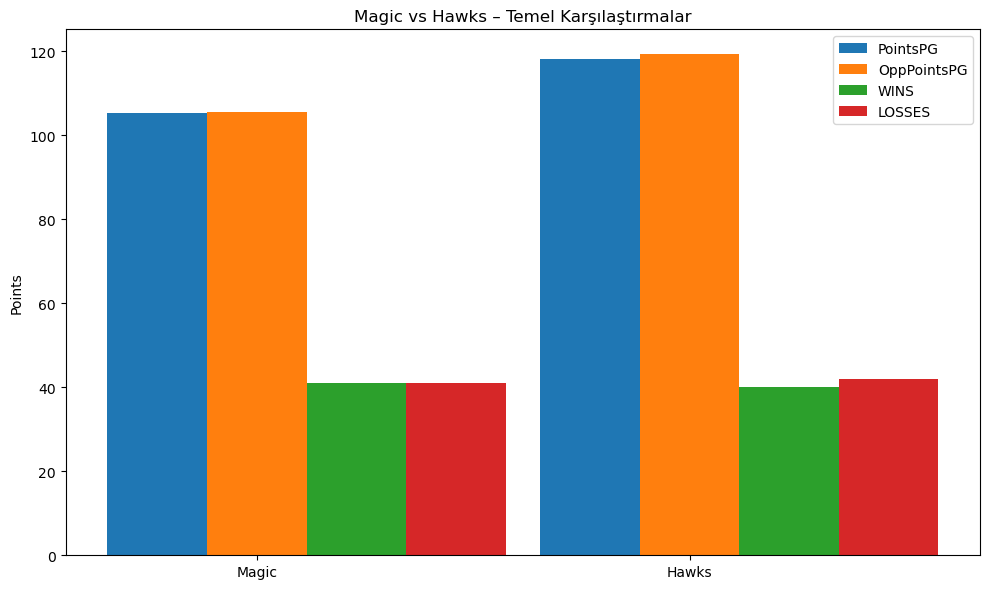

In [8]:

plt.figure(figsize=(10, 6))

metrics = ['PointsPG', 'OppPointsPG', "WINS", 'LOSSES'] 
team_names = teams_to_compare['TeamName']
values = [teams_to_compare[metric].values for metric in metrics]
x = range(len(team_names))
bar_width = 0.23
for i, metric_values in enumerate(values):
    plt.bar(
        [p + bar_width*i for p in x], 
        metric_values, 
        width=bar_width, 
        label=metrics[i]
    )
plt.xticks([p + bar_width for p in x], team_names)
plt.ylabel("Points")
plt.title("Magic vs Hawks – Temel Karşılaştırmalar")
plt.legend()
plt.tight_layout()
plt.show()


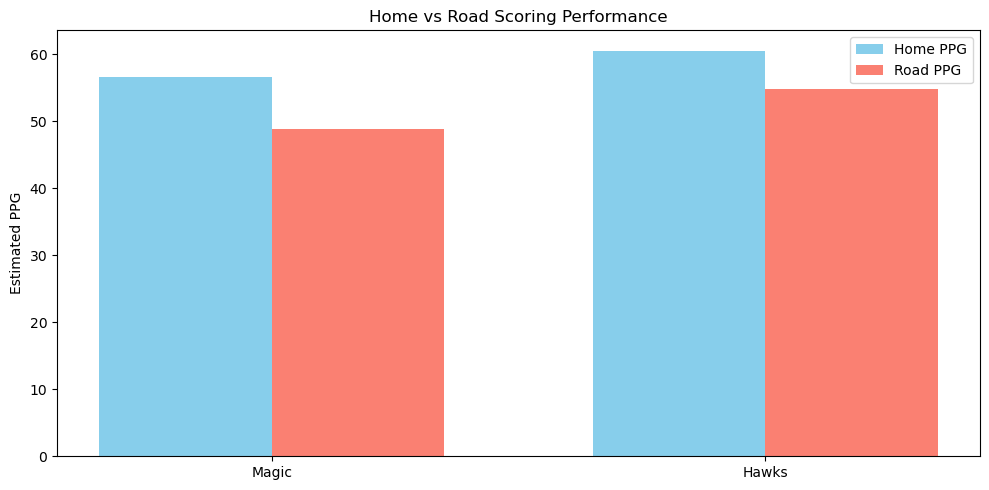

In [9]:
plt.figure(figsize=(10, 5))

home_ppg = teams_to_compare['HOME'].apply(lambda x: int(x.split('-')[0])) / 41 * teams_to_compare['PointsPG']
road_ppg = teams_to_compare['ROAD'].apply(lambda x: int(x.split('-')[0])) / 41 * teams_to_compare['PointsPG']

x = range(len(teams_to_compare))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], home_ppg, width=bar_width, label='Home PPG', color='skyblue')
plt.bar([i + bar_width/2 for i in x], road_ppg, width=bar_width, label='Road PPG', color='salmon')

plt.xticks(x, teams_to_compare['TeamName'])
plt.ylabel('Estimated PPG')
plt.title('Home vs Road Scoring Performance')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
def get_head_to_head_games_from_stats_df(teams_df, season='2024-25'):

    teams_info_df = pd.DataFrame(teams.get_teams())

    team1 = teams_df.iloc[0]
    team2 = teams_df.iloc[1]

    team1_id = team1["TeamID"]
    team2_id = team2["TeamID"]

    team1_abbr = teams_info_df[teams_info_df["id"] == team1_id]["abbreviation"].values[0]
    team2_abbr = teams_info_df[teams_info_df["id"] == team2_id]["abbreviation"].values[0]

    games_team1 = leaguegamefinder.LeagueGameFinder(
        team_id_nullable=team1_id,
        season_nullable=season,
        season_type_nullable='Regular Season'
    ).get_data_frames()[0]

    games_team2 = leaguegamefinder.LeagueGameFinder(
        team_id_nullable=team2_id,
        season_nullable=season,
        season_type_nullable='Regular Season'
    ).get_data_frames()[0]

    h2h1 = games_team1[games_team1["MATCHUP"].str.contains(team2_abbr)]
    h2h2 = games_team2[games_team2["MATCHUP"].str.contains(team1_abbr)]

    h2h_combined = pd.concat([h2h1, h2h2], ignore_index=True)
    #h2h_combined = h2h_combined.drop_duplicates(subset="GAME_ID")
    h2h_combined = h2h_combined.sort_values(by="GAME_DATE")

    return h2h_combined


In [11]:
h2h_df = get_head_to_head_games_from_stats_df(teams_to_compare)
h2h_df


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
3,22024,1610612753,ORL,Orlando Magic,0022400756,2025-02-10,ORL vs. ATL,L,241,106,...,0.833,7,29,36,22,10,8,17,21,-6.0
7,22024,1610612737,ATL,Atlanta Hawks,0022400756,2025-02-10,ATL @ ORL,W,240,112,...,0.857,6,33,39,29,10,3,16,17,6.0
2,22024,1610612753,ORL,Orlando Magic,0022400790,2025-02-20,ORL @ ATL,W,240,114,...,0.684,11,42,53,15,6,7,7,22,6.0
6,22024,1610612737,ATL,Atlanta Hawks,0022400790,2025-02-20,ATL vs. ORL,L,241,108,...,0.679,16,35,51,20,7,4,9,25,-6.0
1,22024,1610612753,ORL,Orlando Magic,0022401149,2025-04-08,ORL vs. ATL,W,240,119,...,0.677,13,30,43,23,13,6,13,20,7.0
5,22024,1610612737,ATL,Atlanta Hawks,0022401149,2025-04-08,ATL @ ORL,L,241,112,...,0.818,14,27,41,25,7,6,18,26,-7.0
0,22024,1610612753,ORL,Orlando Magic,0022401186,2025-04-13,ORL @ ATL,L,240,105,...,0.667,12,31,43,25,11,5,14,8,-12.0
4,22024,1610612737,ATL,Atlanta Hawks,0022401186,2025-04-13,ATL vs. ORL,W,241,117,...,0.600,9,35,44,32,8,2,15,15,12.0


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
3,22024,1610612753,ORL,Orlando Magic,0022400756,2025-02-10,ORL vs. ATL,L,241,106,...,0.833,7,29,36,22,10,8,17,21,-6.0
7,22024,1610612737,ATL,Atlanta Hawks,0022400756,2025-02-10,ATL @ ORL,W,240,112,...,0.857,6,33,39,29,10,3,16,17,6.0


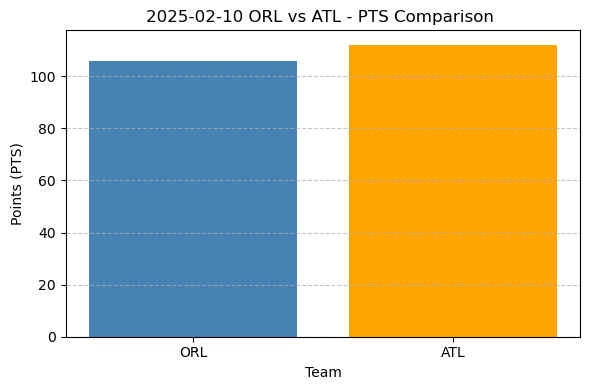

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
2,22024,1610612753,ORL,Orlando Magic,0022400790,2025-02-20,ORL @ ATL,W,240,114,...,0.684,11,42,53,15,6,7,7,22,6.0
6,22024,1610612737,ATL,Atlanta Hawks,0022400790,2025-02-20,ATL vs. ORL,L,241,108,...,0.679,16,35,51,20,7,4,9,25,-6.0


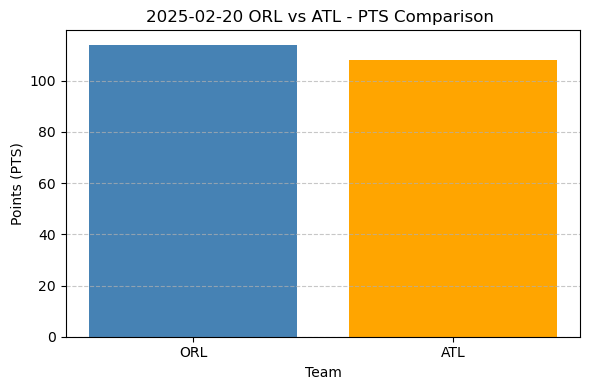

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
1,22024,1610612753,ORL,Orlando Magic,0022401149,2025-04-08,ORL vs. ATL,W,240,119,...,0.677,13,30,43,23,13,6,13,20,7.0
5,22024,1610612737,ATL,Atlanta Hawks,0022401149,2025-04-08,ATL @ ORL,L,241,112,...,0.818,14,27,41,25,7,6,18,26,-7.0


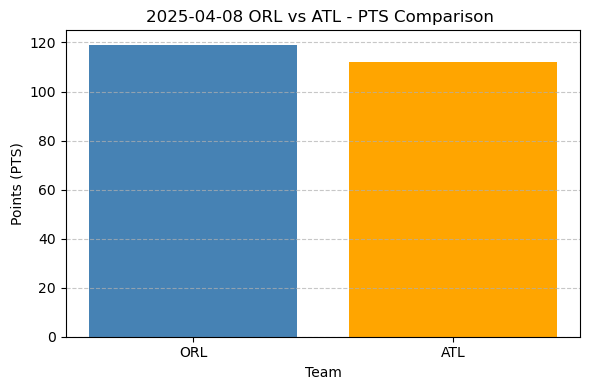

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22024,1610612753,ORL,Orlando Magic,0022401186,2025-04-13,ORL @ ATL,L,240,105,...,0.667,12,31,43,25,11,5,14,8,-12.0
4,22024,1610612737,ATL,Atlanta Hawks,0022401186,2025-04-13,ATL vs. ORL,W,241,117,...,0.600,9,35,44,32,8,2,15,15,12.0


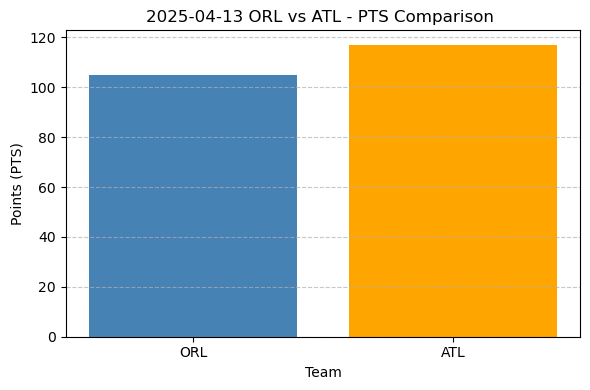

In [12]:
def compare_matches(df):
    result_df = pd.DataFrame()

    for i, matches in df.iterrows():
        for j, match in df.iterrows():
            if i < j and matches["GAME_ID"] == match["GAME_ID"] and matches["TEAM_ABBREVIATION"] != match["TEAM_ABBREVIATION"]:
                
                result_df = pd.concat([result_df, pd.DataFrame([matches, match])], ignore_index=True)
                temp_df = pd.DataFrame([matches, match])
                display(temp_df)

                plt.figure(figsize=(6, 4))
                plt.bar(temp_df["TEAM_ABBREVIATION"], temp_df["PTS"], color=["steelblue", "orange"])
                plt.title(f"{matches['GAME_DATE']} {matches['TEAM_ABBREVIATION']} vs {match['TEAM_ABBREVIATION']} - PTS Comparison ")
                plt.ylabel("Points (PTS)")
                plt.xlabel("Team")
                plt.grid(True, axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

                result_df = pd.concat([result_df, pd.DataFrame([matches, match])], ignore_index=True)
                result_df = pd.DataFrame([matches, match])

    return





compare_matches(h2h_df)



In [13]:


def compare_team_stats_h2h(df, metrics=None):
    if metrics is None:
        metrics = ['PTS', 'FG_PCT', 'FG3_PCT', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PLUS_MINUS']

    comparison_results = []

    for i, row1 in df.iterrows():
        for j, row2 in df.iterrows():
            if i < j and row1["GAME_ID"] == row2["GAME_ID"] and row1["TEAM_ABBREVIATION"] != row2["TEAM_ABBREVIATION"]:
                team1 = row1["TEAM_ABBREVIATION"]
                team2 = row2["TEAM_ABBREVIATION"]
                
                match_id = row1["GAME_ID"]
                game_date = row1["GAME_DATE"]

                metric_diffs = {}
                for metric in metrics:
                    metric_diffs[f"{metric}_DIFF"] = row1[metric] - row2[metric]

                comparison_results.append({
                    "GAME_ID": match_id,
                    "DATE": game_date,
                    "TEAM_1": team1,
                    "TEAM_2": team2,
                    **metric_diffs
                })

    return pd.DataFrame(comparison_results)

h2h_compare = compare_team_stats_h2h(h2h_df)
h2h_compare

,GAME_ID,DATE,TEAM_1,TEAM_2,PTS_DIFF,FG_PCT_DIFF,FG3_PCT_DIFF,REB_DIFF,AST_DIFF,TOV_DIFF,STL_DIFF,BLK_DIFF,PLUS_MINUS_DIFF
0,0022400756,2025-02-10,ORL,ATL,-6,-0.020,0.025,-3,-7,1,0,5,-12.0
1,0022400790,2025-02-20,ORL,ATL,6,0.092,-0.074,2,-5,-2,-1,3,12.0
2,0022401149,2025-04-08,ORL,ATL,7,0.045,0.071,2,-2,-5,6,0,14.0
3,0022401186,2025-04-13,ORL,ATL,-12,-0.079,0.004,-1,-7,-1,3,3,-24.0


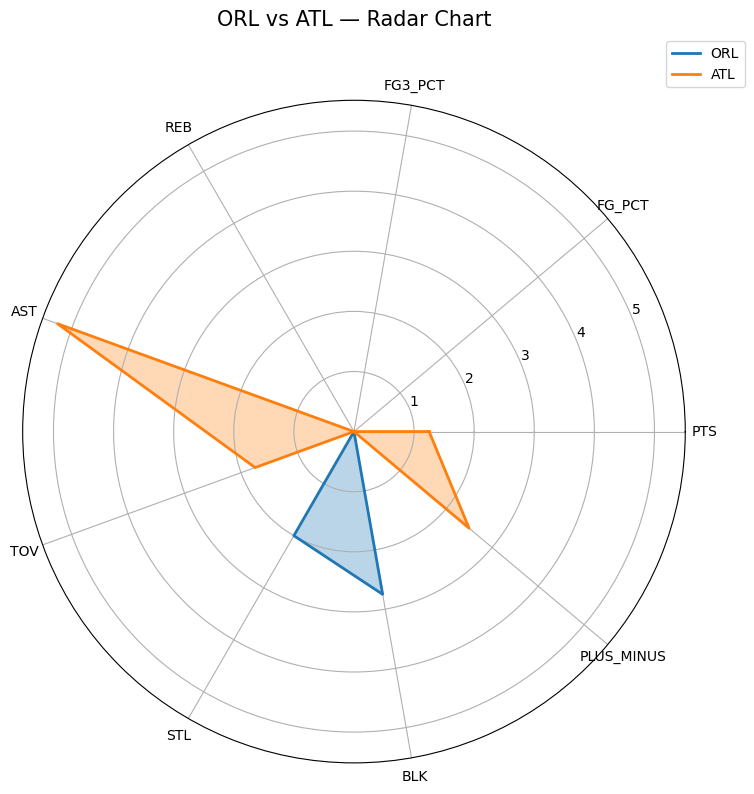

In [14]:


def plot_radar_chart(df):

    stats = ['PTS_DIFF', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'REB_DIFF', 'AST_DIFF', 'TOV_DIFF', 'STL_DIFF', 'BLK_DIFF', 'PLUS_MINUS_DIFF']
    labels = [s.replace('_DIFF', '') for s in stats]

    team1 = df["TEAM_1"].iloc[0]
    team2 = df["TEAM_2"].iloc[0]

    avg_diffs = df[stats].mean()

    values1 = [max(0, v) for v in avg_diffs]
    values2 = [abs(min(0, v)) for v in avg_diffs]

    angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
    values1 += values1[:1]
    values2 += values2[:1]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values1, linewidth=2, linestyle='solid', label=team1)
    ax.fill(angles, values1, alpha=0.3)

    ax.plot(angles, values2, linewidth=2, linestyle='solid', label=team2)
    ax.fill(angles, values2, alpha=0.3)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f"{team1} vs {team2} — Radar Chart", size=15, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.show()
plot_radar_chart(h2h_compare)

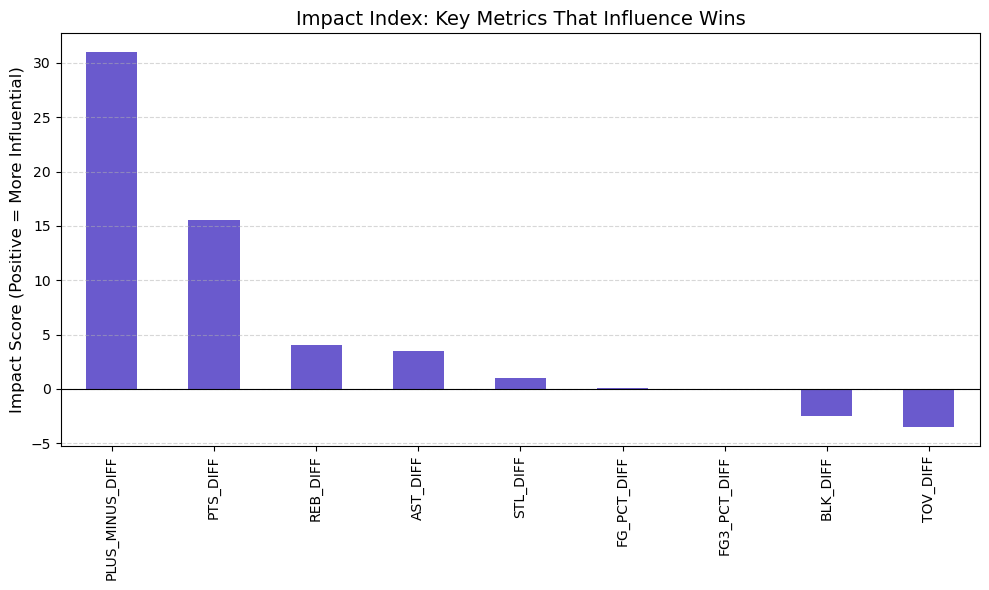

PLUS_MINUS_DIFF    31.000
PTS_DIFF           15.500
REB_DIFF            4.000
AST_DIFF            3.500
STL_DIFF            1.000
FG_PCT_DIFF         0.118
FG3_PCT_DIFF       -0.016
BLK_DIFF           -2.500
TOV_DIFF           -3.500
dtype: float64

In [22]:
def calculate_impact_index(df):
    stats = [col for col in df.columns if col.endswith('_DIFF')]

    team1_wins = df[df["PTS_DIFF"] > 0]
    team2_wins = df[df["PTS_DIFF"] < 0]

    team1_avg = team1_wins[stats].mean()
    team2_avg = team2_wins[stats].mean()

    impact_index = team1_avg - team2_avg
    impact_index = impact_index.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    impact_index.plot(kind='bar', color='slateblue')
    plt.title("Impact Index: Key Metrics That Influence Wins", fontsize=14)
    plt.ylabel("Impact Score (Positive = More Influential)", fontsize=12)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return impact_index
calculate_impact_index(h2h_compare)


In [16]:
def get_boxscore_data(df):
    game_id_list = df["GAME_ID"].unique()
    all_stats = []

    for game_id in game_id_list:
        try:
            boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
            player_stats = boxscore.get_data_frames()[0]
            player_stats['GAME_ID'] = game_id
            all_stats.append(player_stats)
            time.sleep(1)
        except Exception as e:
            print(f"Error fetching game_id {game_id}: {e}")

    return pd.concat(all_stats, ignore_index=True)

player_stats_h2h = get_boxscore_data(h2h_df)
player_stats_h2h


/var/folders/jl/m9thb3l97_14j8thlylmz5v40000gn/T/ipykernel_42268/3821162838.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_stats, ignore_index=True)


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,0022400756,1610612737,ATL,Atlanta,1642258,Zaccharie Risacher,Zaccharie,F,,17:52,...,1.0,1.0,2.0,4.0,1.0,0.0,0.0,1.0,11.0,10.0
1,0022400756,1610612737,ATL,Atlanta,1631243,Mouhamed Gueye,Mouhamed,F,,14:52,...,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,8.0
2,0022400756,1610612737,ATL,Atlanta,1630168,Onyeka Okongwu,Onyeka,C,,28:32,...,1.0,6.0,7.0,2.0,1.0,1.0,2.0,2.0,9.0,4.0
3,0022400756,1610612737,ATL,Atlanta,1630700,Dyson Daniels,Dyson,G,,33:12,...,0.0,6.0,6.0,4.0,4.0,1.0,1.0,2.0,10.0,0.0
4,0022400756,1610612737,ATL,Atlanta,1629027,Trae Young,Trae,G,,36:35,...,1.0,4.0,5.0,8.0,1.0,0.0,9.0,1.0,19.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0022401149,1610612753,ORL,Orlando,1628371,Jonathan Isaac,Jonathan,,,11:08,...,4.0,1.0,5.0,1.0,0.0,0.0,2.0,3.0,5.0,-5.0
75,0022401149,1610612753,ORL,Orlando,203914,Gary Harris,Gary,,,7:55,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0
76,0022401149,1610612753,ORL,Orlando,1629048,Goga Bitadze,Goga,,DNP - Coach's Decision,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,0022401149,1610612753,ORL,Orlando,1641783,Tristan da Silva,Tristan,,DNP - Coach's Decision,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def calculate_player_averages(df):
    player_avg = df.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION']).agg({
        'PTS': 'mean',
        'REB': 'mean',
        'AST': 'mean',
        'STL': 'mean',
        'BLK': 'mean',
        'TO': 'mean',
        'MIN': 'count'  
    }).rename(columns={'MIN': 'GP'}).reset_index()

    player_avg[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']] = player_avg[
        ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TO']].round(1)

    return player_avg.sort_values(by='PTS', ascending=False)
player_averages = calculate_player_averages(player_stats_h2h)
player_averages


,PLAYER_NAME,TEAM_ABBREVIATION,PTS,REB,AST,STL,BLK,TO,GP,TOV
21,Paolo Banchero,ORL,33.3,8.7,4.3,0.0,0.7,3.333333,3,3.3
23,Trae Young,ATL,28.3,3.0,8.0,1.0,0.0,5.666667,3,5.7
9,Franz Wagner,ORL,28.0,6.7,4.7,1.3,0.3,1.666667,3,1.7
20,Onyeka Okongwu,ATL,16.7,9.3,3.0,1.3,0.7,2.000000,3,2.0
2,Caris LeVert,ATL,14.7,6.0,0.7,0.7,0.0,0.666667,3,0.7
8,Dyson Daniels,ATL,11.7,7.3,3.7,2.7,1.0,1.666667,3,1.7
28,Zaccharie Risacher,ATL,10.0,5.0,2.0,0.7,0.3,0.333333,3,0.3
27,Wendell Carter Jr.,ORL,10.0,8.7,1.0,2.0,1.3,1.666667,3,1.7
17,Kentavious Caldwell-Pope,ORL,9.0,3.0,1.0,1.7,0.0,1.333333,3,1.3
4,Cole Anthony,ORL,8.3,2.7,3.0,1.7,0.7,2.000000,3,2.0


In [18]:
def get_top_players(df, stat='PTS', top_n=5):
    top_players = df.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION'])[stat].sum().reset_index()
    return top_players.sort_values(by=stat, ascending=False).head(top_n)
top_players = get_top_players(player_averages, stat=["PTS",'AST',"REB"], top_n=5)
top_players

,PLAYER_NAME,TEAM_ABBREVIATION,PTS,AST,REB
21,Paolo Banchero,ORL,33.3,4.3,8.7
23,Trae Young,ATL,28.3,8.0,3.0
9,Franz Wagner,ORL,28.0,4.7,6.7
20,Onyeka Okongwu,ATL,16.7,3.0,9.3
2,Caris LeVert,ATL,14.7,0.7,6.0


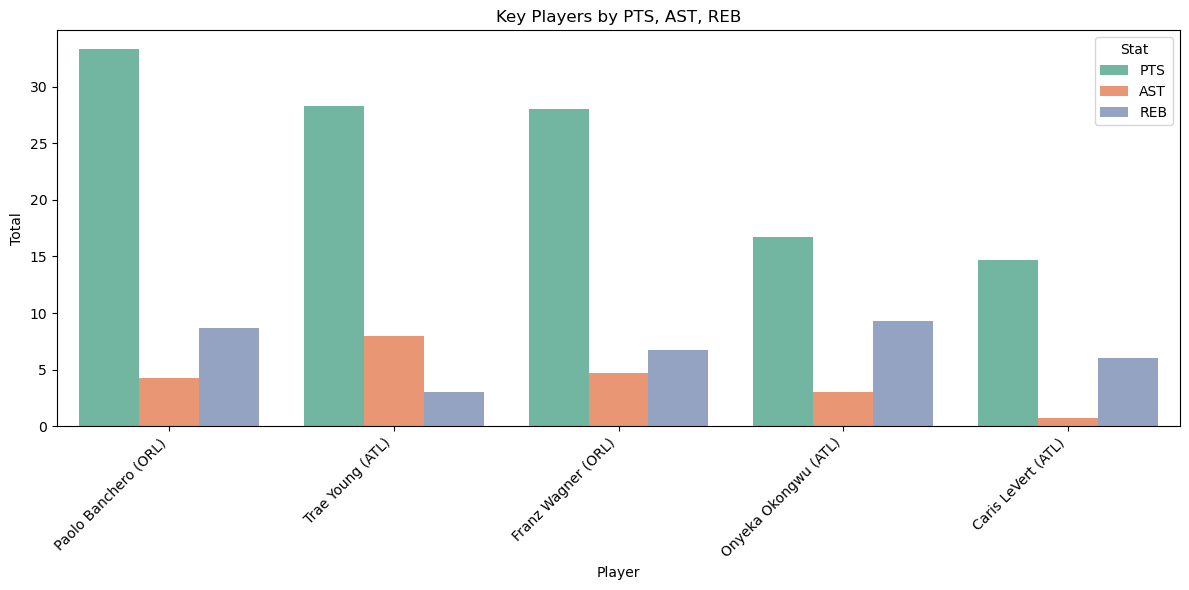

In [20]:

def plot_multiple_stats(df, stats=["PTS", "AST", "REB"]):
    df["PLAYER"] = df["PLAYER_NAME"] + " (" + df["TEAM_ABBREVIATION"] + ")"

    df_melted = df.melt(id_vars=["PLAYER"], value_vars=stats,
                        var_name="Stat", value_name="Value")

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x="PLAYER", y="Value", hue="Stat", palette="Set2")
    plt.title("Key Players by PTS, AST, REB")
    plt.ylabel("Total")
    plt.xlabel("Player")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Stat")
    plt.tight_layout()
    plt.show()
plot_multiple_stats(top_players, stats=["PTS", "AST", "REB"])